<a href="https://colab.research.google.com/github/stakunlena/ich_python_for_DA_HW/blob/main/Stakun_HW_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Домашняя работа №20**
Используйте датасет PRSA_Data_Dingling_20130301-20170228.csv по [ссылке](https://archive.ics.uci.edu/dataset/501/beijing+multi+site+air+quality+data).

Объедините прогнозы, полученные с помощью моделей ARIMA, SARIMA и Prophet, чтобы повысить точность предсказаний.

Инструкции:
1. Загрузите набор данных и выберите данные о концентрации PM2.5.
1. Агрегируйте данные по месяцам.
1. Сделайте прогноз на год с помощью моделей ARIMA, SARIMA и Prophet.
1. Объедините прогнозы всех трех моделей (возьмите их среднее арифметическое) и постройте график комбинированного прогноза.

In [60]:
!pip uninstall prophet -y
!pip install prophet --upgrade --no-cache-dir

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 104.2 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Python for data analysis/HW_20_dataset/PRSA_Data_Dingling_20130301-20170228.csv')   # абсолютный путь из корня
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,3.0,NaN,200.0,82.0,-2.3,1020.8,-19.7,0.0,E,0.5,Dingling
1,2,2013,3,1,1,7.0,7.0,3.0,NaN,200.0,80.0,-2.5,1021.3,-19.0,0.0,ENE,0.7,Dingling
2,3,2013,3,1,2,5.0,5.0,3.0,2.0,200.0,79.0,-3.0,1021.3,-19.9,0.0,ENE,0.2,Dingling
3,4,2013,3,1,3,6.0,6.0,3.0,NaN,200.0,79.0,-3.6,1021.8,-19.1,0.0,NNE,1.0,Dingling
4,5,2013,3,1,4,5.0,5.0,3.0,NaN,200.0,81.0,-3.5,1022.3,-19.4,0.0,N,2.1,Dingling


In [3]:
df.shape

(35064, 18)

Выбираем и агрегируем по месяцам данные о концентрации PM2.5

In [4]:
# Создаём столбец с датой (без учёта часа)
df["datetime"] = pd.to_datetime(df[["year", "month", "day", "hour"]])

# Группировка по годам и месяцам, расчёт среднего значения PM2.5
pm25_monthly = (
    df.groupby(["year", "month"])["PM2.5"]
    .mean()
    .reset_index()
    .rename(columns={"PM2.5": "pm25_mean"})
)

# Добавим удобный формат даты (год-месяц)
pm25_monthly["year_month"] = pd.to_datetime(
    pm25_monthly["year"].astype(str) + "-" + pm25_monthly["month"].astype(str).str.zfill(2)
)

# Смотрим первые строки
print(pm25_monthly.head())

   year  month  pm25_mean year_month
0  2013      3  95.705645 2013-03-01
1  2013      4  55.206506 2013-04-01
2  2013      5  71.402266 2013-05-01
3  2013      6  85.520950 2013-06-01
4  2013      7  54.012676 2013-07-01


График средней концентрации PM2.5 по месяцам

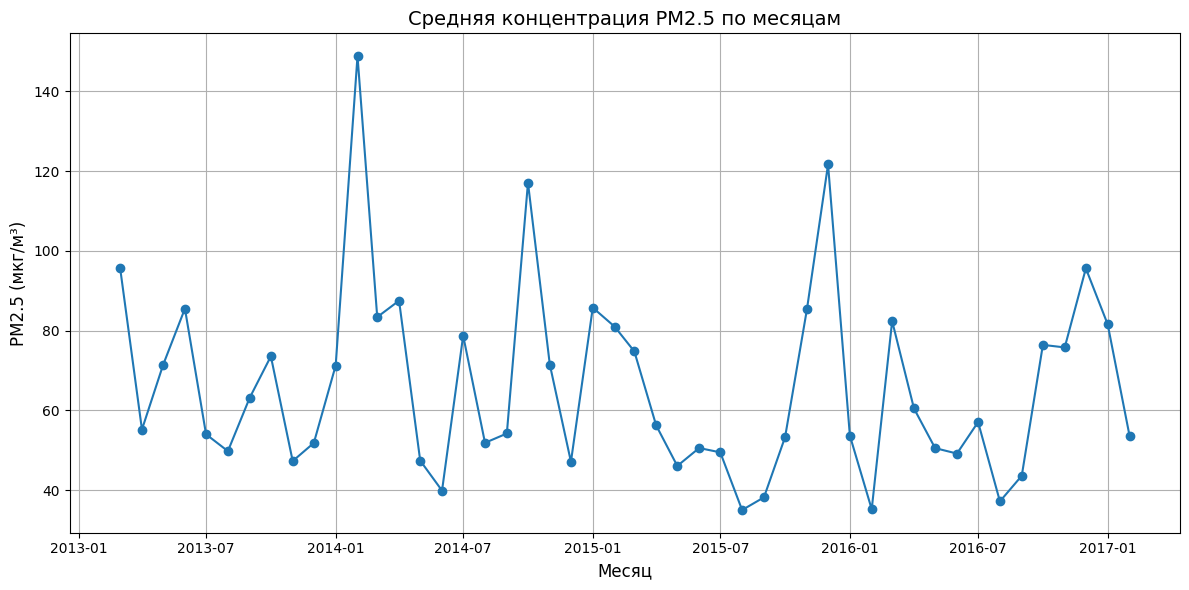

In [5]:
# Строим график
plt.figure(figsize=(12, 6))
plt.plot(pm25_monthly["year_month"], pm25_monthly["pm25_mean"], marker="o", linewidth=1.5)

plt.title("Средняя концентрация PM2.5 по месяцам", fontsize=14)
plt.xlabel("Месяц", fontsize=12)
plt.ylabel("PM2.5 (мкг/м³)", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

Подготовка данных к моделированию

In [6]:
pm25_monthly = pm25_monthly.set_index("year_month").sort_index()

# Удаляем пропуски и задаем частоту
series = pm25_monthly["pm25_mean"].dropna().asfreq("MS")  # начало месяца (MS)

ARIMA

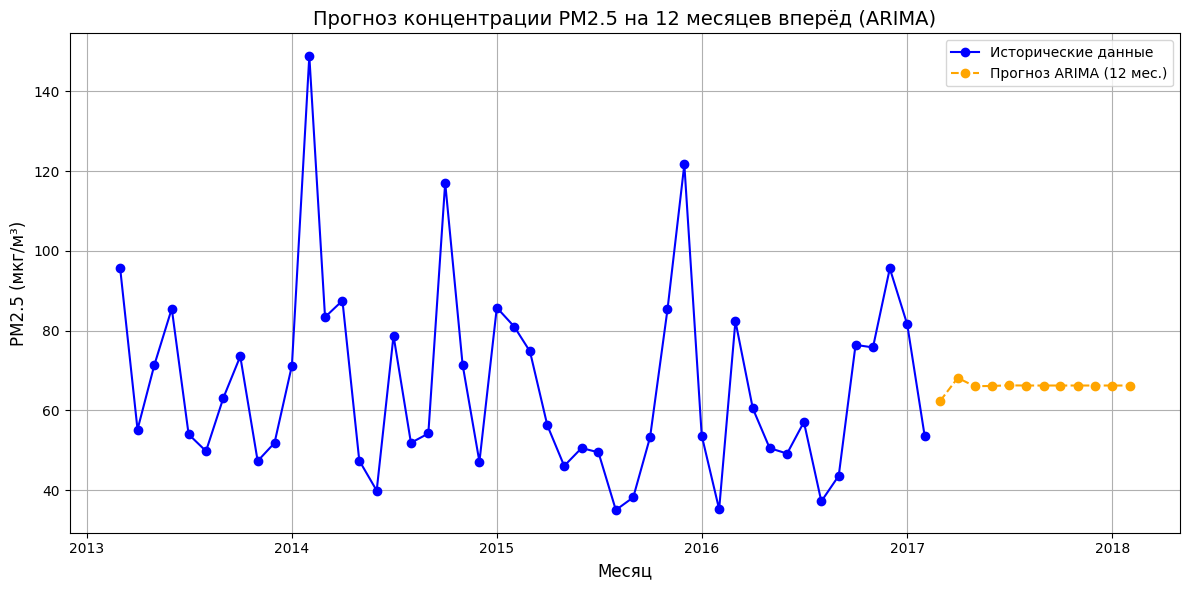

In [7]:
# --- 1. Обучение модели ARIMA ---
model = ARIMA(series, order=(2, 1, 2))
model_fit = model.fit()

# --- 2. Прогноз на 12 месяцев вперёд ---
forecast = model_fit.forecast(steps=12)
forecast_index = pd.date_range(start=series.index[-1] + pd.offsets.MonthBegin(1),
                               periods=12, freq="MS")
forecast = pd.Series(forecast.values, index=forecast_index)

# --- 3. Визуализация ---
plt.figure(figsize=(12, 6))
plt.plot(series.index, series.values, label="Исторические данные", color="blue", marker="o")
plt.plot(forecast.index, forecast.values, label="Прогноз ARIMA (12 мес.)",
         color="orange", marker="o", linestyle="--")

plt.title("Прогноз концентрации PM2.5 на 12 месяцев вперёд (ARIMA)", fontsize=14)
plt.xlabel("Месяц", fontsize=12)
plt.ylabel("PM2.5 (мкг/м³)", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Модель ARIMA основывается на авторегрессии и скользящем среднем — она «учится» на предыдущих значениях, но не знает о сезонности, если её явно не задать.
* Поскольку в коде использовалась обычная ARIMA, а не SARIMA, сезонный компонент (зимние пики и летние спады) не учтён.
* Поэтому линия прогноза получилась почти горизонтальной — это ожидаемое поведение для несезонной ARIMA.

SARIMA

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


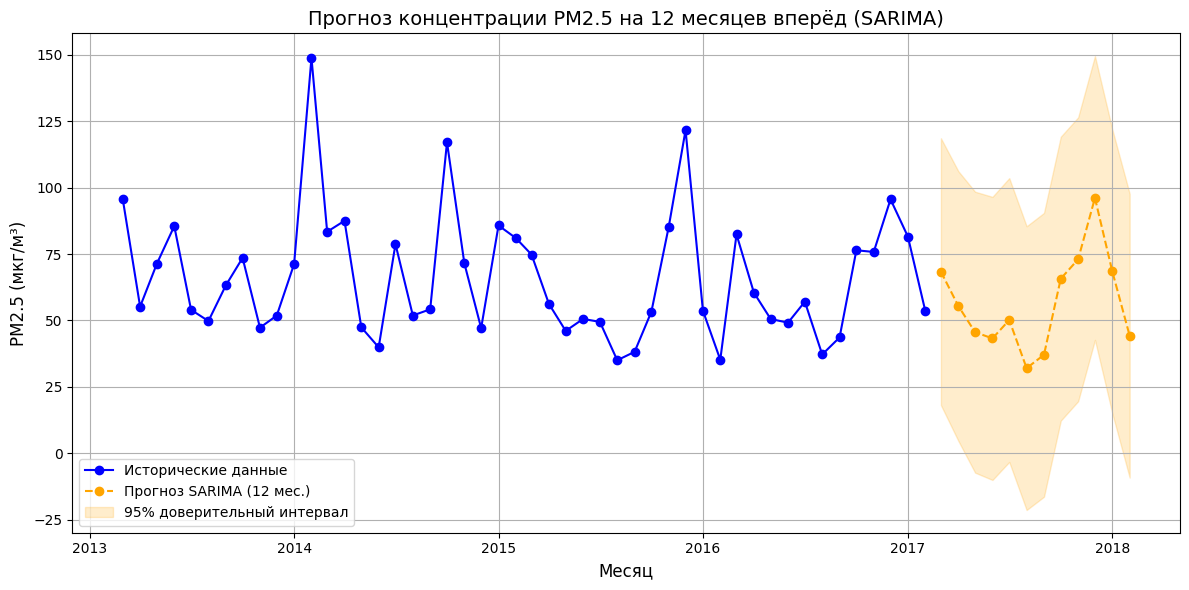

In [8]:
# --- 1. Обучение модели SARIMA ---
model = SARIMAX(series, order=(2, 1, 2), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)

# --- 2. Прогноз на 12 месяцев ---
forecast_res = model_fit.get_forecast(steps=12)
forecast = forecast_res.predicted_mean
conf_int = forecast_res.conf_int()

# Приводим к float и выравниваем по индексу
conf_int = conf_int.astype(float).reindex(forecast.index)

# --- 3. Визуализация ---
plt.figure(figsize=(12, 6))
plt.plot(series.index, series, label="Исторические данные", color="blue", marker="o")
plt.plot(forecast.index, forecast, label="Прогноз SARIMA (12 мес.)",
         color="orange", marker="o", linestyle="--")

# Добавим доверительный интервал (работает корректно)
plt.fill_between(forecast.index,
                 conf_int.iloc[:, 0].values,
                 conf_int.iloc[:, 1].values,
                 color="orange", alpha=0.2, label="95% доверительный интервал")

plt.title("Прогноз концентрации PM2.5 на 12 месяцев вперёд (SARIMA)", fontsize=14)
plt.xlabel("Месяц", fontsize=12)
plt.ylabel("PM2.5 (мкг/м³)", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

* SARIMA уловила цикличность загрязнения воздуха — обычно зимой PM2.5 растёт, летом снижается.
* Средний уровень (центр интервала) показывает ожидаемую концентрацию, а зона неопределённости указывает, что точное значение может колебаться примерно на ±10–15 мкг/м³.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


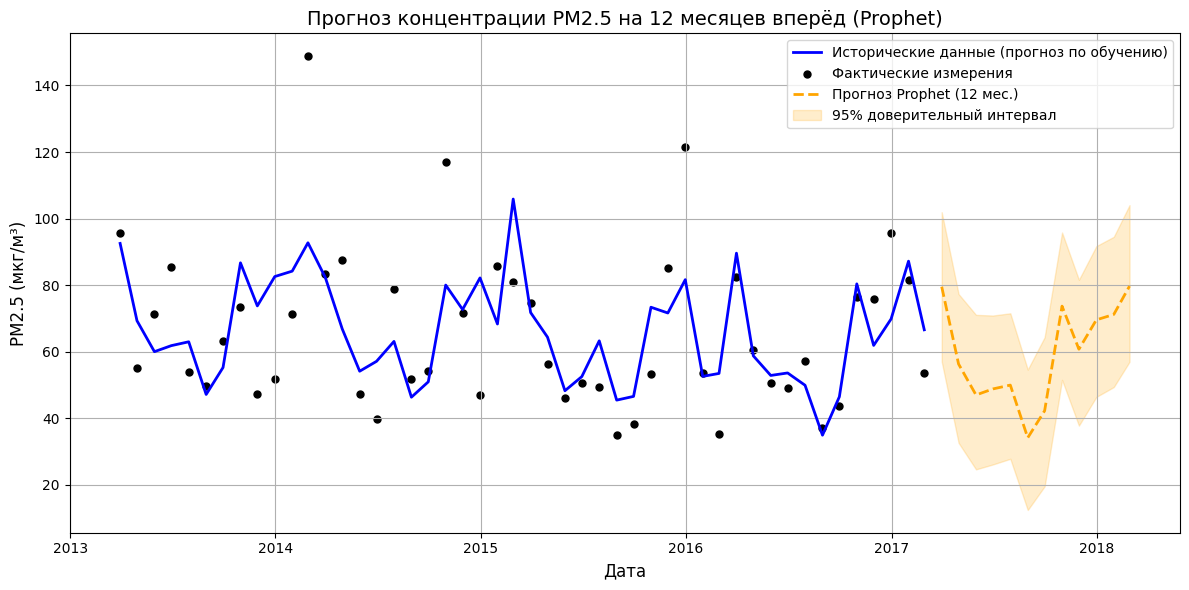

In [15]:
# --- 1. Подготовка данных ---
pm25_monthly_prophet = df.resample("ME", on="datetime")["PM2.5"].mean().reset_index()
pm25_monthly_prophet.columns = ["ds", "y"]
pm25_monthly_prophet.dropna(inplace=True)

# --- 2. Обучение модели ---
model = Prophet(yearly_seasonality=True)
model.fit(pm25_monthly_prophet)

# --- 3. Прогноз на 12 месяцев вперёд ---
future = model.make_future_dataframe(periods=12, freq="ME")
forecast = model.predict(future)

# --- 4. Объединение фактических и прогнозных данных ---
historical = forecast[forecast["ds"] <= pm25_monthly_prophet["ds"].max()]
predicted = forecast[forecast["ds"] > pm25_monthly_prophet["ds"].max()]

# --- 5. Визуализация ---
plt.figure(figsize=(12, 6))

# Фактические данные
plt.plot(historical["ds"], historical["yhat"], color="blue", label="Исторические данные (прогноз по обучению)", linewidth=2)
plt.scatter(pm25_monthly_prophet["ds"], pm25_monthly_prophet["y"], color="black", s=25, label="Фактические измерения")

# Прогноз
plt.plot(predicted["ds"], predicted["yhat"], color="orange", linestyle="--", linewidth=2, label="Прогноз Prophet (12 мес.)")

# Доверительный интервал
plt.fill_between(predicted["ds"],
                 predicted["yhat_lower"],
                 predicted["yhat_upper"],
                 color="orange", alpha=0.2, label="95% доверительный интервал")

# --- Оформление ---
plt.title("Прогноз концентрации PM2.5 на 12 месяцев вперёд (Prophet)", fontsize=14)
plt.xlabel("Дата", fontsize=12)
plt.ylabel("PM2.5 (мкг/м³)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Prophet автоматически выделяет общий тренд (долгосрочную тенденцию).
Prophet использует годовую сезонность (`yearly_seasonality=True`), поэтому модель «знает», что каждый год есть повторяющиеся циклы.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


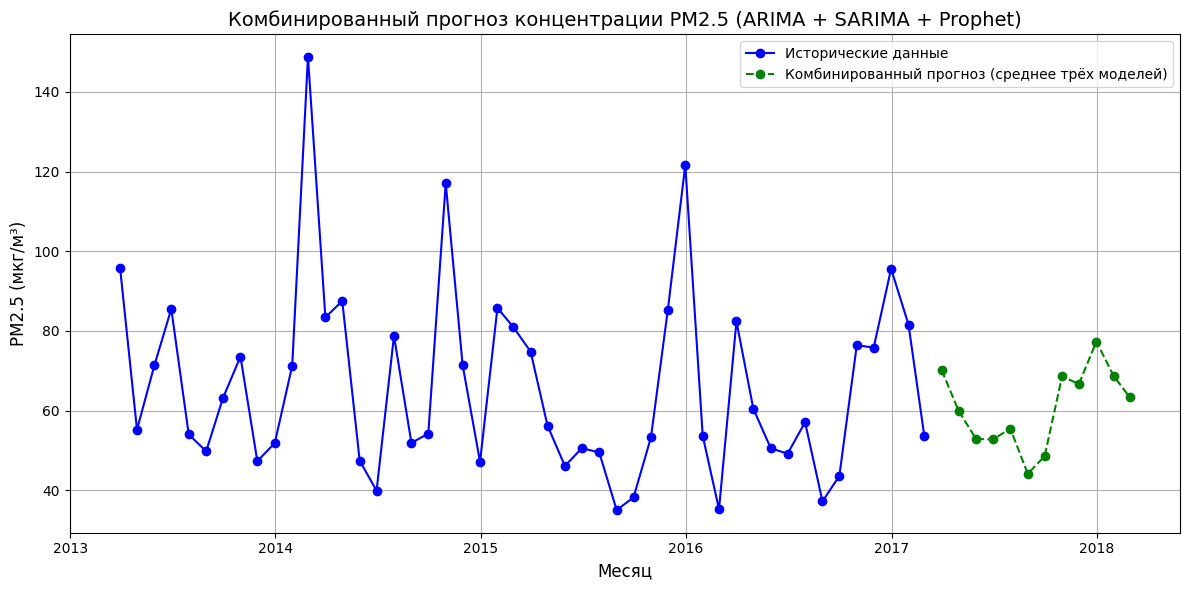

In [16]:
# --- 1. Подготовка данных ---
series = df.resample("ME", on="datetime")["PM2.5"].mean().dropna().asfreq("ME")

# --- 2. ARIMA ---
model_arima = ARIMA(series, order=(2, 1, 2))
fit_arima = model_arima.fit()
forecast_arima = fit_arima.forecast(steps=12)
forecast_arima.index = pd.date_range(series.index[-1] + pd.offsets.MonthEnd(), periods=12, freq="ME")

# --- 3. SARIMA ---
model_sarima = SARIMAX(series, order=(2, 1, 2), seasonal_order=(1, 1, 1, 12))
fit_sarima = model_sarima.fit(disp=False)
forecast_sarima = fit_sarima.get_forecast(steps=12).predicted_mean
forecast_sarima.index = forecast_arima.index

# --- 4. Prophet ---
df_prophet = series.reset_index()
df_prophet.columns = ["ds", "y"]
model_prophet = Prophet(yearly_seasonality=True)
model_prophet.fit(df_prophet)
future = model_prophet.make_future_dataframe(periods=12, freq="ME")
forecast_prophet = model_prophet.predict(future)
forecast_prophet = forecast_prophet.set_index("ds").loc[forecast_arima.index, "yhat"]

# --- 5. Комбинированный прогноз ---
combined_forecast = pd.DataFrame({
    "ARIMA": forecast_arima,
    "SARIMA": forecast_sarima,
    "Prophet": forecast_prophet
})
combined_forecast["Combined"] = combined_forecast.mean(axis=1)

# --- 6. Визуализация ---
plt.figure(figsize=(12, 6))
plt.plot(series.index, series.values, label="Исторические данные", color="blue", marker="o")
plt.plot(forecast_arima.index, combined_forecast["Combined"], color="green", marker="o", linestyle="--", label="Комбинированный прогноз (среднее трёх моделей)")

plt.title("Комбинированный прогноз концентрации PM2.5 (ARIMA + SARIMA + Prophet)", fontsize=14)
plt.xlabel("Месяц", fontsize=12)
plt.ylabel("PM2.5 (мкг/м³)", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()